# idealo Case Study - Product Analyst

---
### Sandeep Uprety
---
## Table of Contents

**Task 1: User Journey Analysis**
1. Data Loading and Exploration
2. Data Cleaning
3. Question 1: Most Typical User Flow
4. Question 2: Sessions from Google
5. Question 3: Homepage to Product Page
6. Question 4: OOP Impressions by Category
7. Additional Insights
8. SQL Queries

**Task 2: Feature Improvement**
1. Homepage KPIs
2. Proposed Feature
3. Success Metrics
4. Implementation Plan

---
## Task 1: User Journey Analysis

### 1.1 Data Loading and Exploration

In [162]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

IDEALO_ORANGE = '#FF6600'
IDEALO_BLUE = '#0066CC'

In [163]:
df_raw = pd.read_csv('dataset_pa_1.csv', low_memory=False)

print(f"Dataset Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"\nColumns: {list(df_raw.columns)}")

Dataset Shape: 136,290 rows × 9 columns

Columns: ['session_id', 'trace_time', 'page_template', 'url', 'http_referer_apexdomain', 'device_type', 'page_type', 'is_bot', 'root_category_id']


### 1.2 First Look at the Data

In [164]:
df_raw.head(10)

,session_id,trace_time,page_template,url,http_referer_apexdomain,device_type,page_type,is_bot,root_category_id
0,0x00007A64C3D681AE,1.680402e+12,MainSearchProductCategory,https://www.idealo.co.uk/mscat.html?q=59752165...,NaN,PC,pageimpression,True,NaN
1,0x00009578E6DCBFF0,1.680641e+12,MainProductCategory,https://www.idealo.co.uk/,NaN,PC,pageimpression,True,NaN
2,0x00009578E6DCBFF0,1.680641e+12,GoToShop,https://www.idealo.co.uk/offerpage/relocate?ca...,NaN,PC,leadout,True,3326.0
3,0x0001148F2860FD73,1.680687e+12,OffersOfProduct,https://www.idealo.co.uk/compare/200653179/sau...,NaN,PC,pageimpression,True,9908.0
4,0x00019B7B44586D47,1.680341e+12,MainProductCategory,https://www.idealo.co.uk/,NaN,Crawler,pageimpression,True,NaN
5,0x0001D20FE8C077E3,1.680499e+12,OffersOfProduct,https://www.idealo.co.uk/compare/200512390/jea...,idealo.co.uk,PC,pageimpression,True,3932.0
6,0x0001D20FE8C077E3,1.680499e+12,OffersOfProduct,https://www.idealo.co.uk/compare/200233031/lan...,idealo.co.uk,PC,pageimpression,True,3932.0
7,0x0001D20FE8C077E3,1.680499e+12,OffersOfProduct,https://www.idealo.co.uk/compare/6055660/prada...,idealo.co.uk,PC,pageimpression,True,3932.0
8,0x0001D20FE8C077E3,1.680499e+12,OffersOfProduct,https://www.idealo.co.uk/compare/200876247/cer...,idealo.co.uk,PC,pageimpression,True,3932.0
9,0x0001D20FE8C077E3,1.680499e+12,OffersOfProduct,https://www.idealo.co.uk/compare/1959667/kaneb...,idealo.co.uk,PC,pageimpression,True,3932.0


### 1.3 Data Quality Check

In [165]:
print("Unique values per column\n")

for col in df_raw.columns:
    n_unique = df_raw[col].nunique()
    n_missing = df_raw[col].isna().sum()
    print(f"{col}: {n_unique:,} unique | {n_missing:,} missing")

Unique values per column

session_id: 69,255 unique | 6 missing
trace_time: 136,202 unique | 16 missing
page_template: 9 unique | 16 missing
url: 81,427 unique | 16 missing
http_referer_apexdomain: 128 unique | 72,220 missing
device_type: 5 unique | 16 missing
page_type: 2 unique | 16 missing
is_bot: 2 unique | 16 missing
root_category_id: 11 unique | 53,529 missing


### 1.4 Understanding Key Columns

In [166]:
print("page_template")
print(df_raw['page_template'].value_counts())

print("\ndevice_type")
print(df_raw['device_type'].value_counts())

print("\npage_type")
print(df_raw['page_type'].value_counts())

print("\nis_bot")
print(df_raw['is_bot'].value_counts())

page_template
page_template
OffersOfProduct              53508
MainProductCategory          29826
MainSearchProductCategory    23273
GoToShop                     21352
ProductCategory               8108
SubProductCategory             111
Manufacturer                    47
PrivacyPolicy                   27
GTAC                            22
Name: count, dtype: int64

device_type
device_type
PC         93220
Crawler    19603
Phone      19233
Tablet      2816
Unknown     1402
Name: count, dtype: int64

page_type
page_type
pageimpression    114922
leadout            21352
Name: count, dtype: int64

is_bot
is_bot
True     109571
False     26703
Name: count, dtype: int64


### 1.5 Data Cleaning

The data contains bot traffic which needs to be removed for accurate user analysis.

In [167]:
# Remove bot traffic 
df = df_raw[df_raw['is_bot'] == False].copy()

print(f"Before: {len(df_raw):,} rows")
print(f"After:  {len(df):,} rows ({len(df)/len(df_raw)*100:.1f}% of data)")
print(f"Unique sessions: {df['session_id'].nunique():,}")

Before: 136,290 rows
After:  26,703 rows (19.6% of data)
Unique sessions: 9,405


### 1.6 Data Preparation

In [168]:
# Convert timestamp to datetime and sort chronologically
df['datetime'] = pd.to_datetime(df['trace_time'], unit='ms')
df = df.sort_values(['session_id', 'trace_time']).reset_index(drop=True)

print(f"Date range: {df['datetime'].min().strftime('%Y-%m-%d')} to {df['datetime'].max().strftime('%Y-%m-%d')}")
print(f"Total days: {(df['datetime'].max() - df['datetime'].min()).days + 1}")

Date range: 2023-04-01 to 2023-04-07
Total days: 7


---
## Question 1: Most Typical User Flow

In [169]:
# Create journey path for each session (sequence of pages visited)
journeys = df.groupby('session_id')['page_template'].apply(lambda x: ' -> '.join(x))

print(f"Total sessions: {len(journeys):,}")
print(f"\nSample journeys:")
for i, (session, journey) in enumerate(journeys.head(5).items()):
    print(f"  {journey}")

Total sessions: 9,405

Sample journeys:
  OffersOfProduct -> OffersOfProduct -> OffersOfProduct
  OffersOfProduct -> OffersOfProduct -> OffersOfProduct
  OffersOfProduct -> OffersOfProduct -> GoToShop
  OffersOfProduct -> OffersOfProduct -> GoToShop -> GoToShop -> OffersOfProduct -> OffersOfProduct
  OffersOfProduct -> OffersOfProduct


In [170]:
journey_counts = journeys.value_counts()
total_sessions = len(journeys)

print("Top 15 most common user journeys\n")

for i, (journey, count) in enumerate(journey_counts.head(15).items(), 1):
    pct = count / total_sessions * 100
    print(f"{i:2}. ({count:,} sessions, {pct:.1f}%) {journey}")

Top 15 most common user journeys

 1. (3,334 sessions, 35.4%) OffersOfProduct
 2. (727 sessions, 7.7%) MainProductCategory
 3. (696 sessions, 7.4%) OffersOfProduct -> OffersOfProduct -> OffersOfProduct
 4. (644 sessions, 6.8%) OffersOfProduct -> OffersOfProduct
 5. (614 sessions, 6.5%) OffersOfProduct -> GoToShop
 6. (359 sessions, 3.8%) ProductCategory
 7. (304 sessions, 3.2%) OffersOfProduct -> OffersOfProduct -> GoToShop
 8. (169 sessions, 1.8%) OffersOfProduct -> OffersOfProduct -> GoToShop -> OffersOfProduct
 9. (147 sessions, 1.6%) OffersOfProduct -> OffersOfProduct -> OffersOfProduct -> OffersOfProduct -> OffersOfProduct
10. (145 sessions, 1.5%) OffersOfProduct -> OffersOfProduct -> OffersOfProduct -> OffersOfProduct
11. (103 sessions, 1.1%) OffersOfProduct -> GoToShop -> GoToShop
12. (71 sessions, 0.8%) ProductCategory -> OffersOfProduct -> ProductCategory
13. (63 sessions, 0.7%) OffersOfProduct -> OffersOfProduct -> OffersOfProduct -> OffersOfProduct -> OffersOfProduct -> Offe

### Landing and Exit Pages

In [171]:
# First page of each session = landing page
landing_pages = df.groupby('session_id')['page_template'].first().value_counts()

print("Landing pages (where users enter the site)\n")

for page, count in landing_pages.items():
    pct = count / total_sessions * 100
    print(f"{page}: {count:,} ({pct:.1f}%)")

Landing pages (where users enter the site)

OffersOfProduct: 7,343 (78.1%)
MainProductCategory: 1,130 (12.0%)
ProductCategory: 718 (7.6%)
MainSearchProductCategory: 143 (1.5%)
GoToShop: 40 (0.4%)
SubProductCategory: 23 (0.2%)
PrivacyPolicy: 4 (0.0%)
GTAC: 3 (0.0%)
Manufacturer: 1 (0.0%)


### Session Depth

In [172]:
# Last page of each session = exit page
exit_pages = df.groupby('session_id')['page_template'].last().value_counts()

print("Exit pages (where users leave the site)\n")

for page, count in exit_pages.items():
    pct = count / total_sessions * 100
    print(f"{page}: {count:,} ({pct:.1f}%)")

Exit pages (where users leave the site)

OffersOfProduct: 6,010 (63.9%)
GoToShop: 1,670 (17.8%)
MainProductCategory: 804 (8.5%)
ProductCategory: 656 (7.0%)
MainSearchProductCategory: 239 (2.5%)
SubProductCategory: 15 (0.2%)
Manufacturer: 5 (0.1%)
GTAC: 3 (0.0%)
PrivacyPolicy: 3 (0.0%)


In [173]:
session_depth = df.groupby('session_id').size()

print("Session depth statistics\n")
print(f"Average pages per session: {session_depth.mean():.2f}")
print(f"Median pages per session: {session_depth.median():.0f}")
print(f"Max pages in a session: {session_depth.max()}")

bounce_count = (session_depth == 1).sum()
bounce_rate = bounce_count / total_sessions * 100
print(f"\nSingle-page sessions (bounce): {bounce_count:,} ({bounce_rate:.1f}%)")

Session depth statistics

Average pages per session: 2.84
Median pages per session: 2
Max pages in a session: 116

Single-page sessions (bounce): 4,491 (47.8%)


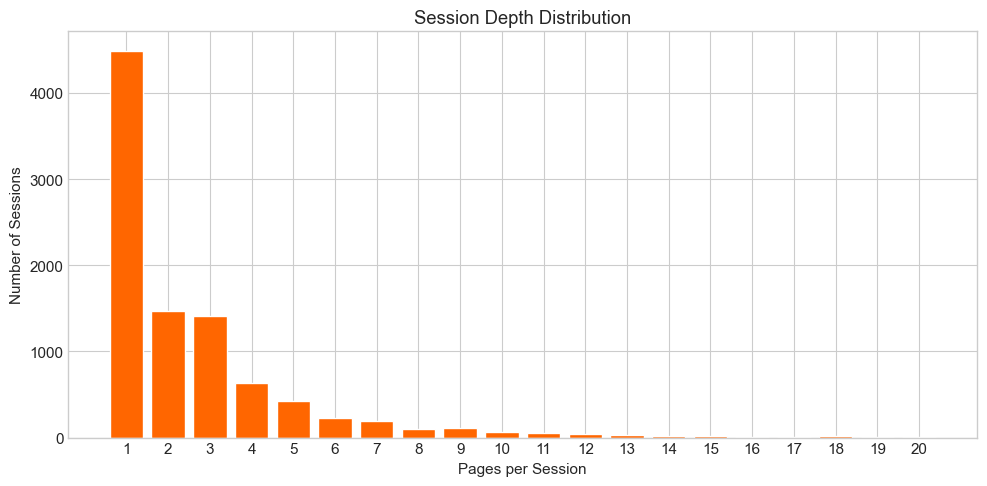

In [174]:
fig, ax = plt.subplots(figsize=(10, 5))

depth_dist = session_depth.value_counts().sort_index().head(20)
ax.bar(depth_dist.index, depth_dist.values, color=IDEALO_ORANGE, edgecolor='white')

ax.set_xlabel('Pages per Session')
ax.set_ylabel('Number of Sessions')
ax.set_title('Session Depth Distribution')
ax.set_xticks(range(1, 21))

plt.tight_layout()
plt.show()

### Top 3 Learnings


### Question 1: Top 3 Learnings from User Flow Analysis

**1. Product pages are the real landing pages, not the homepage**

78% of users land directly on product pages (OffersOfProduct), likely coming from Google searches for specific products. Only 12% start at the homepage. This means product pages need to do double duty - they're not just for conversion, they're the first impression.

**2. High bounce rate signals engagement opportunity**

48% of users leave after viewing just one page. The most common journey is a single product page visit and exit. This could mean users aren't finding what they need, or there's not enough incentive to explore further.

**3. Users who compare products are more likely to convert**

Looking at the conversion journeys (those ending in GoToShop), users typically browse 2-3 product pages before clicking out to a shop. This suggests that helping users compare products could improve conversion rates.

---
## Question 2: Sessions from Google

In [175]:
# Get the first touchpoint (entry referer) for each session
first_touch = df.sort_values('trace_time').groupby('session_id').head(1).set_index('session_id')

# Count sessions from Google
google_sessions = first_touch['http_referer_apexdomain'].str.contains('google', case=False, na=False).sum()
google_share = google_sessions / total_sessions * 100

print(f"Sessions from Google: {google_sessions:,} out of {total_sessions:,}")
print(f"Share: {google_share:.2f}%")

Sessions from Google: 6,600 out of 9,405
Share: 70.18%


### Traffic Source Breakdown

In [195]:
def categorize_source(referer):
    if pd.isna(referer):
        return 'Direct'
    referer = referer.lower()
    if 'google' in referer:
        return 'Google'
    elif 'bing' in referer:
        return 'Bing'
    elif 'idealo' in referer:
        return 'Internal'
    elif any(x in referer for x in ['yahoo', 'duckduckgo', 'ecosia', 'brave', 'startpage']):
        return 'Other Search'
    elif any(x in referer for x in ['facebook', 'tiktok', 'youtube', 'instagram', 'twitter']):
        return 'Social'
    else:
        return 'Other'

first_touch['traffic_source'] = first_touch['http_referer_apexdomain'].apply(categorize_source)
traffic_breakdown = first_touch['traffic_source'].value_counts()

print("Traffic source breakdown\n")
for source, count in traffic_breakdown.items():
    pct = count / total_sessions * 100
    print(f"{source}: {count:,} ({pct:.1f}%)")

Traffic source breakdown

Google: 6,600 (70.2%)
Direct: 1,134 (12.1%)
Internal: 797 (8.5%)
Other Search: 413 (4.4%)
Bing: 267 (2.8%)
Other: 104 (1.1%)
Social: 90 (1.0%)


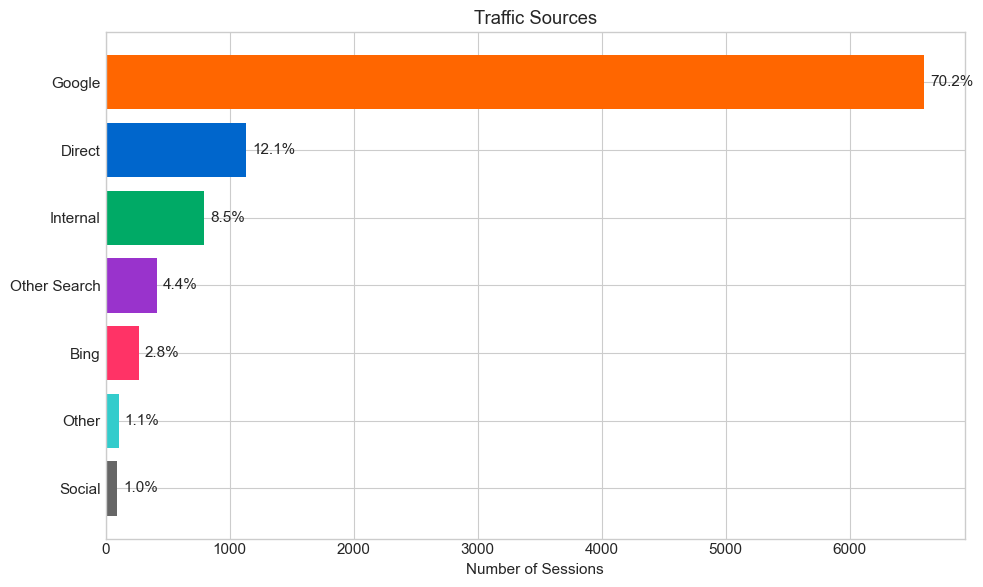

In [177]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = [IDEALO_ORANGE, IDEALO_BLUE, '#00AA66', '#9933CC', '#FF3366', '#33CCCC', '#666666']
bars = ax.barh(traffic_breakdown.index[::-1], traffic_breakdown.values[::-1], color=colors[::-1])

ax.set_xlabel('Number of Sessions')
ax.set_title('Traffic Sources')

for bar in bars:
    width = bar.get_width()
    pct = width / total_sessions * 100
    ax.text(width + 50, bar.get_y() + bar.get_height()/2, f'{pct:.1f}%', va='center')

plt.tight_layout()
plt.show()

---
## Question 3: Homepage to Product Page Conversion

In [178]:
# Sessions that landed on MainProductCategory (homepage)
home_landing_sessions = first_touch[first_touch['page_template'] == 'MainProductCategory'].index
home_landing_count = len(home_landing_sessions)

# Sessions that viewed at least one OOP
sessions_with_oop = df[df['page_template'] == 'OffersOfProduct']['session_id'].unique()

# Sessions that landed on homepage and saw OOP
home_to_oop = set(home_landing_sessions) & set(sessions_with_oop)
home_to_oop_count = len(home_to_oop)

print(f"Sessions landing on homepage: {home_landing_count:,} ({home_landing_count/total_sessions*100:.1f}%)")
print(f"Of those, sessions that saw OOP: {home_to_oop_count:,}")
print(f"\nShare of total sessions (home landing AND saw OOP): {home_to_oop_count/total_sessions*100:.2f}%")
print(f"Homepage to OOP conversion rate: {home_to_oop_count/home_landing_count*100:.1f}%")

Sessions landing on homepage: 1,130 (12.0%)
Of those, sessions that saw OOP: 252

Share of total sessions (home landing AND saw OOP): 2.68%
Homepage to OOP conversion rate: 22.3%


---
## Question 4: OOP Impressions by Category

In [179]:
# Filter to OOP pages only
oop_pages = df[df['page_template'] == 'OffersOfProduct']
total_oop = len(oop_pages)

# Count by root category
oop_by_category = oop_pages['root_category_id'].value_counts()

print(f"Total OOP impressions: {total_oop:,}\n")
print("OOP impressions by root category\n")

for cat_id, count in oop_by_category.items():
    pct = count / total_oop * 100
    print(f"Category {int(cat_id)}: {count:,} ({pct:.1f}%)")

Total OOP impressions: 17,984

OOP impressions by root category

Category 30311: 4,899 (27.2%)
Category 9908: 4,660 (25.9%)
Category 3626: 4,257 (23.7%)
Category 3932: 1,299 (7.2%)
Category 3326: 1,081 (6.0%)
Category 3686: 769 (4.3%)
Category 2400: 411 (2.3%)
Category 4033: 310 (1.7%)
Category 12913: 205 (1.1%)
Category 7032: 93 (0.5%)


### Category Mapping

In [180]:
# Category names from URL patterns in the data
category_names = {
    30311: 'Electronics & Computers',
    9908: 'Shoes & Footwear',
    3626: 'Clothing & Apparel',
    3932: 'Beauty & Cosmetics',
    3326: 'Gaming & Toys',
    3686: 'Home & Garden',
    2400: 'Automotive',
    4033: 'Health & Pharmacy',
    12913: 'Baby & Kids',
    7032: 'Sports & Outdoors'
}

print("OOP impressions by category\n")

for cat_id, count in oop_by_category.items():
    pct = count / total_oop * 100
    name = category_names.get(int(cat_id), 'Unknown')
    print(f"{name}: {count:,} ({pct:.1f}%)")

OOP impressions by category

Electronics & Computers: 4,899 (27.2%)
Shoes & Footwear: 4,660 (25.9%)
Clothing & Apparel: 4,257 (23.7%)
Beauty & Cosmetics: 1,299 (7.2%)
Gaming & Toys: 1,081 (6.0%)
Home & Garden: 769 (4.3%)
Automotive: 411 (2.3%)
Health & Pharmacy: 310 (1.7%)
Baby & Kids: 205 (1.1%)
Sports & Outdoors: 93 (0.5%)


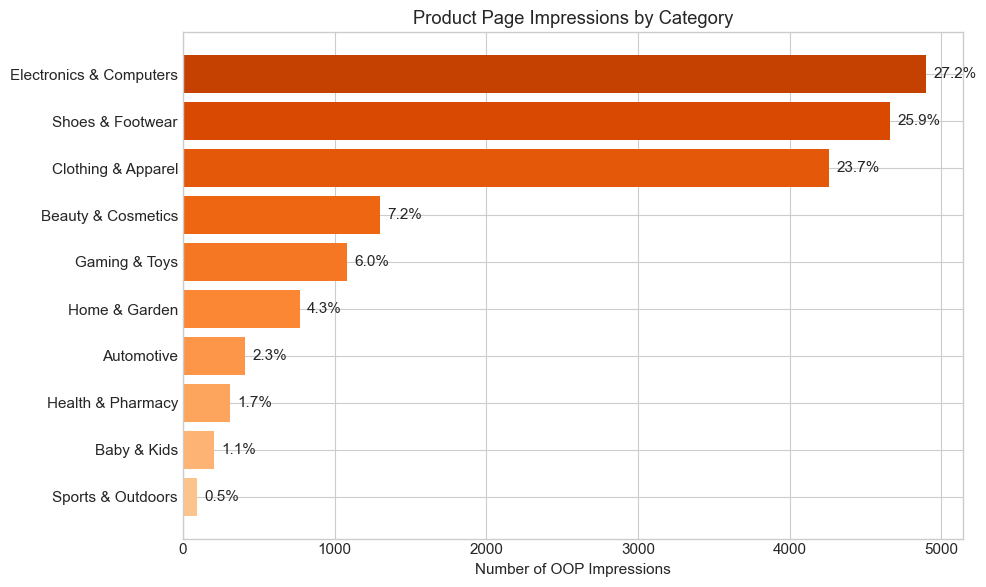

In [181]:
fig, ax = plt.subplots(figsize=(10, 6))

categories = [category_names.get(int(cat_id), 'Unknown') for cat_id in oop_by_category.index]
values = oop_by_category.values
percentages = values / total_oop * 100

colors = plt.cm.Oranges(np.linspace(0.8, 0.3, len(categories)))
bars = ax.barh(categories[::-1], values[::-1], color=colors[::-1])

ax.set_xlabel('Number of OOP Impressions')
ax.set_title('Product Page Impressions by Category')

for bar, pct in zip(bars, percentages[::-1]):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f'{pct:.1f}%', va='center')

plt.tight_layout()
plt.show()

---
## Additional Insights

### Conversion Analysis

In [182]:
# Sessions that had at least one leadout (GoToShop)
sessions_with_leadout = df[df['page_type'] == 'leadout']['session_id'].unique()
leadout_set = set(sessions_with_leadout)

overall_conversion = len(sessions_with_leadout) / total_sessions * 100

print(f"Overall conversion rate (sessions with GoToShop): {overall_conversion:.1f}%")
print(f"Converted sessions: {len(sessions_with_leadout):,} out of {total_sessions:,}")

Overall conversion rate (sessions with GoToShop): 25.3%
Converted sessions: 2,384 out of 9,405


### Device Distribution

In [183]:
print("Conversion rate by device\n")

for device in first_touch['device_type'].value_counts().index:
    device_sessions = first_touch[first_touch['device_type'] == device].index
    converted = len(set(device_sessions) & leadout_set)
    total = len(device_sessions)
    conv_rate = converted / total * 100
    print(f"{device}: {converted:,}/{total:,} ({conv_rate:.1f}%)")

Conversion rate by device

Phone: 1,266/5,409 (23.4%)
PC: 1,023/3,592 (28.5%)
Tablet: 94/387 (24.3%)
Unknown: 1/17 (5.9%)


In [184]:
print("Conversion rate by landing page\n")

landing_page_counts = first_touch['page_template'].value_counts()

for page in landing_page_counts.index:
    page_sessions = first_touch[first_touch['page_template'] == page].index
    converted = len(set(page_sessions) & leadout_set)
    total = len(page_sessions)
    if total >= 10:  # only  pages with meaningful traffic
        conv_rate = converted / total * 100
        print(f"{page}: {converted:,}/{total:,} ({conv_rate:.1f}%)")

Conversion rate by landing page

OffersOfProduct: 2,010/7,343 (27.4%)
MainProductCategory: 184/1,130 (16.3%)
ProductCategory: 106/718 (14.8%)
MainSearchProductCategory: 39/143 (27.3%)
GoToShop: 40/40 (100.0%)
SubProductCategory: 5/23 (21.7%)


In [185]:
device_dist = first_touch['device_type'].value_counts()

print("Sessions by device\n")

for device, count in device_dist.items():
    pct = count / total_sessions * 100
    print(f"{device}: {count:,} ({pct:.1f}%)")

Sessions by device

Phone: 5,409 (57.5%)
PC: 3,592 (38.2%)
Tablet: 387 (4.1%)
Unknown: 17 (0.2%)


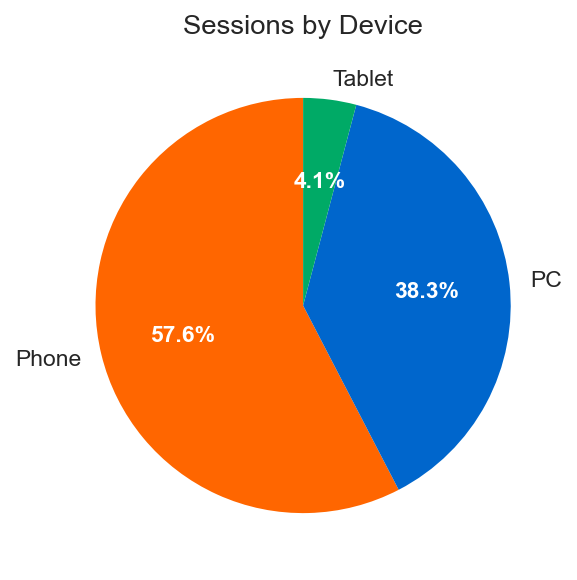

In [186]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

device_data = device_dist[device_dist.index != 'Unknown']
colors = [IDEALO_ORANGE, IDEALO_BLUE, '#00AA66']

wedges, texts, autotexts = ax.pie(device_data.values, labels=device_data.index, autopct='%1.1f%%', 
                                   colors=colors, startangle=90)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax.set_title('Sessions by Device')

plt.tight_layout()
plt.show()

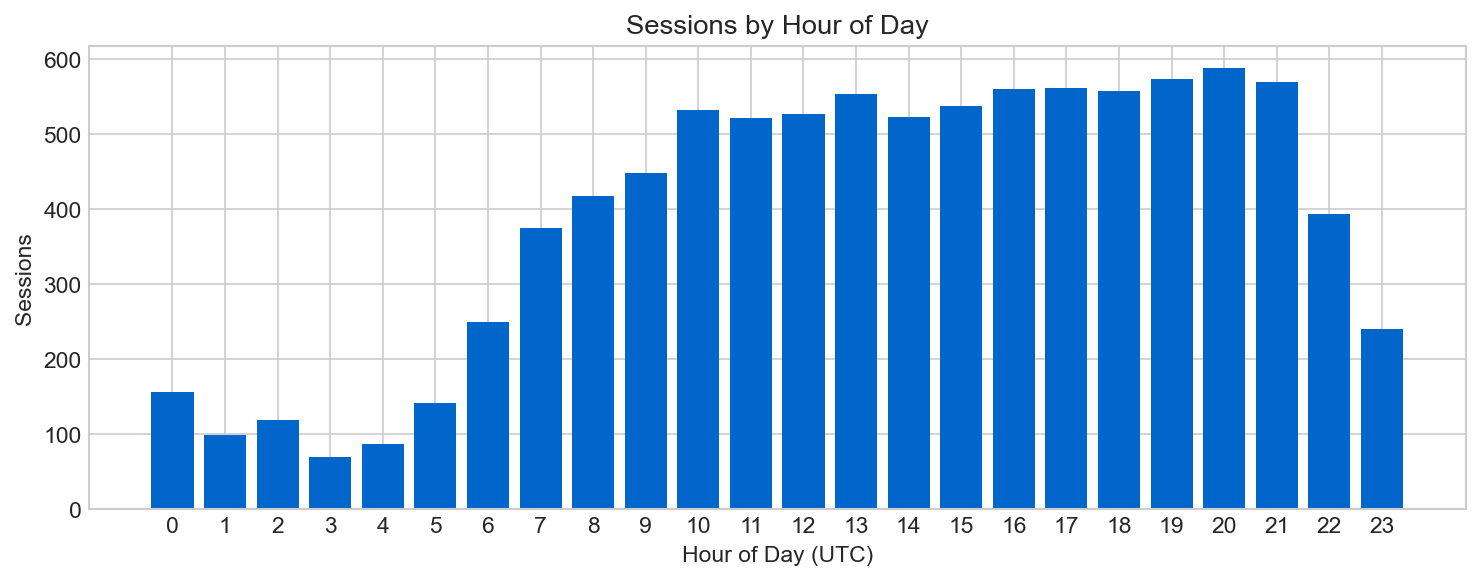


Peak hour: 20:00 UTC (588 sessions)


In [187]:
df['hour'] = df['datetime'].dt.hour
session_hours = df.groupby('session_id')['hour'].first()
hourly_sessions = session_hours.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 4), dpi=150)

ax.bar(hourly_sessions.index, hourly_sessions.values, color=IDEALO_BLUE)
ax.set_xlabel('Hour of Day (UTC)')
ax.set_ylabel('Sessions')
ax.set_title('Sessions by Hour of Day')
ax.set_xticks(range(0, 24))

plt.tight_layout()
plt.show()

peak_hour = hourly_sessions.idxmax()
print(f"\nPeak hour: {peak_hour}:00 UTC ({hourly_sessions.max():,} sessions)")

### Key Metrics Summary

In [188]:
summary = {
    'Metric': [
        'Total Sessions (excl. bots)',
        'Sessions from Google',
        'Homepage Landing -> OOP',
        'Bounce Rate',
        'Overall Conversion Rate',
        'Mobile Traffic (Phone)',
        'Top Category (Electronics)'
    ],
    'Value': [
        f"{total_sessions:,}",
        f"{google_share:.1f}%",
        f"{home_to_oop_count/total_sessions*100:.1f}%",
        f"{bounce_rate:.1f}%",
        f"{overall_conversion:.1f}%",
        f"{device_dist['Phone']/total_sessions*100:.1f}%",
        f"{oop_by_category.iloc[0]/total_oop*100:.1f}%"
    ]
}

pd.DataFrame(summary)

,Metric,Value
0,Total Sessions (excl. bots),"9,405"
1,Sessions from Google,70.2%
2,Homepage Landing -> OOP,2.7%
3,Bounce Rate,47.8%
4,Overall Conversion Rate,25.3%
5,Mobile Traffic (Phone),57.5%
6,Top Category (Electronics),27.2%


# SQL Approach


---
## SQL Queries

Demonstrating the same analysis using SQL.

In [189]:
import sqlite3

conn = sqlite3.connect(':memory:')

# Loading clean dataframe (without bots) into SQLite
df.to_sql('sessions', conn, index=False, if_exists='replace')

print(f"Loaded {len(df):,} rows into 'sessions' table")

Loaded 26,703 rows into 'sessions' table


### Q1 - User Journeys

In [190]:
query = """
WITH ordered_pages AS (
    SELECT 
        session_id,
        page_template,
        ROW_NUMBER() OVER (PARTITION BY session_id ORDER BY trace_time) AS page_order
    FROM sessions
),
journey_paths AS (
    SELECT 
        session_id,
        GROUP_CONCAT(page_template, ' -> ') AS journey
    FROM ordered_pages
    GROUP BY session_id
)
SELECT 
    journey,
    COUNT(*) AS sessions,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM journey_paths), 1) AS percentage
FROM journey_paths
GROUP BY journey
ORDER BY sessions DESC
LIMIT 15
"""

pd.read_sql_query(query, conn)

,journey,sessions,percentage
0,OffersOfProduct,3334,35.4
1,MainProductCategory,727,7.7
2,OffersOfProduct -> OffersOfProduct -> OffersOf...,696,7.4
3,OffersOfProduct -> OffersOfProduct,644,6.8
4,OffersOfProduct -> GoToShop,614,6.5
5,ProductCategory,359,3.8
6,OffersOfProduct -> OffersOfProduct -> GoToShop,304,3.2
7,OffersOfProduct -> OffersOfProduct -> GoToShop...,169,1.8
8,OffersOfProduct -> OffersOfProduct -> OffersOf...,147,1.6
9,OffersOfProduct -> OffersOfProduct -> OffersOf...,145,1.5


###  Q2 - Sessions from Google

In [191]:
query = """
WITH first_touch AS (
    SELECT 
        session_id,
        http_referer_apexdomain,
        ROW_NUMBER() OVER (PARTITION BY session_id ORDER BY trace_time) AS rn
    FROM sessions
)
SELECT 
    SUM(CASE WHEN http_referer_apexdomain LIKE '%google%' THEN 1 ELSE 0 END) AS google_sessions,
    COUNT(*) AS total_sessions,
    ROUND(SUM(CASE WHEN http_referer_apexdomain LIKE '%google%' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS google_share_pct
FROM first_touch
WHERE rn = 1
"""

pd.read_sql_query(query, conn)

,google_sessions,total_sessions,google_share_pct
0,6600,9405,70.18


### Q3 - Homepage to OOP

In [192]:
query = """
WITH landing_page AS (
    SELECT 
        session_id,
        page_template,
        ROW_NUMBER() OVER (PARTITION BY session_id ORDER BY trace_time) AS rn
    FROM sessions
),
home_landings AS (
    SELECT session_id
    FROM landing_page
    WHERE rn = 1 AND page_template = 'MainProductCategory'
),
oop_views AS (
    SELECT DISTINCT session_id
    FROM sessions
    WHERE page_template = 'OffersOfProduct'
),
total AS (
    SELECT COUNT(DISTINCT session_id) AS total_sessions
    FROM landing_page
    WHERE rn = 1
)
SELECT 
    COUNT(DISTINCT h.session_id) AS home_and_oop_sessions,
    (SELECT total_sessions FROM total) AS total_sessions,
    ROUND(COUNT(DISTINCT h.session_id) * 100.0 / (SELECT total_sessions FROM total), 2) AS share_pct
FROM home_landings h
INNER JOIN oop_views o ON h.session_id = o.session_id
"""

pd.read_sql_query(query, conn)

,home_and_oop_sessions,total_sessions,share_pct
0,252,9405,2.68


### Q4 - OOP Impressions by Category

In [193]:
query = """
SELECT 
    CAST(root_category_id AS INTEGER) AS root_category_id,
    COUNT(*) AS oop_impressions,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 1) AS share_pct
FROM sessions
WHERE page_template = 'OffersOfProduct'
    AND root_category_id IS NOT NULL
GROUP BY root_category_id
ORDER BY oop_impressions DESC
"""

pd.read_sql_query(query, conn)

,root_category_id,oop_impressions,share_pct
0,30311,4899,27.2
1,9908,4660,25.9
2,3626,4257,23.7
3,3932,1299,7.2
4,3326,1081,6.0
5,3686,769,4.3
6,2400,411,2.3
7,4033,310,1.7
8,12913,205,1.1
9,7032,93,0.5


### Close Database

In [194]:
conn.close()
print("Database connection closed")

Database connection closed


---
---


## Task 2: Feature Improvement

### 2.1 Most Important KPIs for Homepage

The homepage serves as the main entry point for users who aren't coming from search engines with a specific product in mind. The key metrics I would track are:

**Bounce Rate** - The percentage of users who leave without any interaction. From the data, 64% of homepage visitors exit immediately, which suggests the current page isn't engaging enough.

**Homepage to Product Page Rate** - How many users actually reach a product page (OOP). Currently only 22% of homepage visitors make it to a product page.

**Search Usage Rate** - What percentage of users engage with the search bar. From the data, only 17% of homepage visitors used search.

**Click-Through Rate** - The percentage of users clicking on any element (products, categories, deals). This tells us if the content is relevant and compelling.

**Time to First Click** - How quickly users engage with something. Longer times may indicate confusion or lack of interest.

### 2.2 Proposed Feature: "Popular Comparisons"

**The Problem**

The homepage currently shows deals, bestsellers, and trending categories - but nothing that leverages idealo's core value proposition: price comparison. Users in research mode (deciding between products) don't have a clear starting point.

**The Feature**

Add a "Popular Comparisons" section on the homepage showing head-to-head product comparisons like "iPhone 16 vs Samsung Galaxy S25" or category-based comparisons like "Top 5 Noise-Cancelling Headphones". Each comparison would preview specs and prices across shops.

This gives undecided users a reason to engage and showcases what makes idealo different from regular shopping sites.

**Why This Feature**

This directly addresses the 64% bounce rate by giving browsers something actionable. It differentiates idealo from competitors since no other homepage section highlights the comparison functionality. Most importantly, it helps users who are in the research phase of their buying journey - they haven't decided what to buy yet, and this feature meets them where they are. It also works for all visitors without requiring login or browsing history.

### 2.3 KPIs to Measure Success

To evaluate whether this feature improves the homepage experience, I would track:

**Primary KPIs**

**Comparison Section CTR** - The percentage of homepage visitors who click on a comparison. This directly measures if users find the feature interesting. A target of 5-10% CTR would indicate strong engagement.

**Homepage to OOP Conversion** - Does this feature help more users reach product pages? Currently at 22%, we would want to see an improvement of at least 2-3 percentage points.

**Bounce Rate Reduction** - If the feature is effective, fewer users should leave immediately. The goal would be reducing the 64% bounce rate by 5-10%.

**Secondary KPIs**

**Leadout Rate from Comparison Clicks** - Of users who click on comparisons, how many eventually click through to a shop? This measures if the feature drives actual business value.

**Time on Site** - Users engaging with comparisons should spend more time researching, indicating higher engagement.

### 2.4 How This Feature Goes Live

**Phase 1: Discovery and Planning**

Work with the product manager to define the scope. Analyze existing data to identify which product comparisons are most searched for and which categories have the highest user interest. This helps prioritize what comparisons to show first.

**Phase 2: A/B Test Design**

Set up a controlled experiment where 50% of homepage visitors see the new "Popular Comparisons" section and 50% see the current homepage. The test should run for at least 2-3 weeks to gather enough data and account for weekly patterns.

**Phase 3: Launch and Monitor**

If the A/B test shows positive results (improved CTR, lower bounce rate, higher OOP conversion), roll out to 100% of users. Continue monitoring KPIs for any unexpected changes.

**My Role as Product Analyst**

Before launch, I would analyze historical data to identify the best comparison candidates and help define success metrics and test duration. During the A/B test, I would monitor results daily, check for statistical significance, and flag any issues. After launch, I would build dashboards to track ongoing performance, report insights to stakeholders, and identify optimization opportunities based on user behavior patterns.

---
## Summary

Looking at a week of user data from idealo.co.uk, a few things stand out. Most users (70%) come from Google and land directly on product pages, skipping the homepage entirely. This makes sense for a price comparison site, people search for a specific product and arrive at that page.

The homepage has a challenge though. When users do land there, 64% leave without doing anything. The proposed "Popular Comparisons" feature could help by giving these visitors something engaging to click on, while also highlighting what makes idealo different from regular shopping sites.